In [1]:
from platform import python_version
print("Python version: ", python_version())

import numpy as np
print("Numpy version: ", np.__version__)

import os
current_path = os.getcwd()
PETITE_home_dir= current_path.split('examples')[0]

print("PETITE home directory:", PETITE_home_dir)

dictionary_dir = "data/"

Python version:  3.8.5
Numpy version:  1.24.4
PETITE home directory: /Users/taozhou/Documents/GitHub/PETITE/


In [2]:
# import src
import sys
sys.path.append(PETITE_home_dir)
from src.dark_shower import *
from src.shower import *
import pickle as pk
from matplotlib import pyplot as plt
from tqdm import tqdm
#from tqdm.notebook import tqdm

import matplotlib

from matplotlib.font_manager import FontProperties
from matplotlib.ticker import FixedLocator, MaxNLocator
import cProfile
profile = cProfile.Profile()
import pstats

font0 = FontProperties()
font = font0.copy()
font.set_size(24)
font.set_family('serif')
labelfont=font0.copy()
labelfont.set_size(20)
labelfont.set_weight('bold')
legfont=font0.copy()
legfont.set_size(18)
legfont.set_weight('bold')


def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

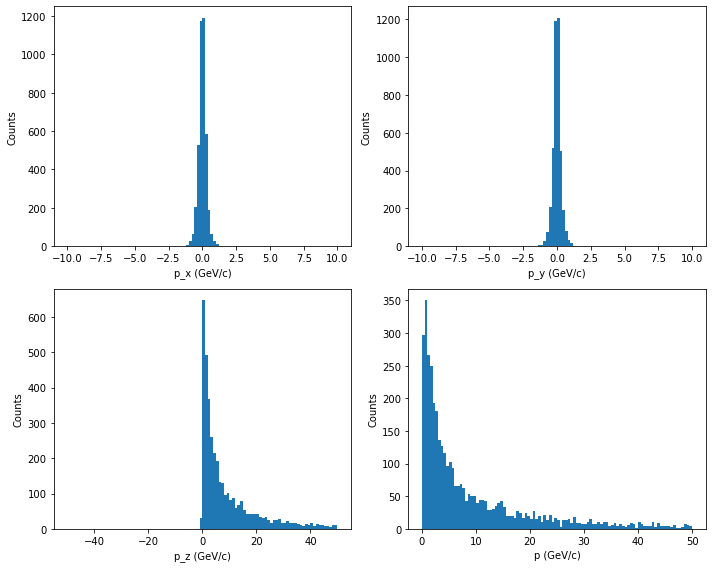

In [6]:
# load data
data = np.loadtxt(PETITE_home_dir + dictionary_dir + 'Pi0_400GeVProtons_1e3POT.txt')
E = data[:,0]
px = data[:,1]
py = data[:,2]
pz = data[:,3]
p = np.sqrt(px**2 + py**2 + pz**2)

# Plot histograms
plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)
plt.hist(px, bins=100, range=(-10, 10))
plt.xlabel('p_x (GeV/c)')
plt.ylabel('Counts')

plt.subplot(2, 2, 2)
plt.hist(py, bins=100, range=(-10, 10))
plt.xlabel('p_y (GeV/c)')
plt.ylabel('Counts')

plt.subplot(2, 2, 3)
plt.hist(pz, bins=100, range=(-50, 50))
plt.xlabel('p_z (GeV/c)')
plt.ylabel('Counts')

plt.subplot(2, 2, 4)
plt.hist(p, bins=100, range=(0, 50))
plt.xlabel('p (GeV/c)')
plt.ylabel('Counts')

plt.tight_layout()
plt.show()


In [3]:
# minimum energy = 0.03 GeV, vector mass = 10 MeV, target_length =0.5m
sTungsten = DarkShower(PETITE_home_dir+dictionary_dir, "tungsten", min_energy=0.030, target_length=0.5, mV_in_GeV=0.01, kinetic_mixing=1.0)

In [4]:
# Set up lists to organize data according to BSM process and parent particle
Energies, Weights, particles = {}, {}, {}
parent_pid_options = [11, -11, 22, 111]
for pr in dark_process_codes:
    Energies[pr] = {}
    Weights[pr] = {}
    particles[pr] = {}
    for pid in parent_pid_options:
        Energies[pr][pid] = []
        Weights[pr][pid] = []
        particles[pr][pid] = []

In [5]:
data = np.loadtxt(PETITE_home_dir + dictionary_dir + 'Pi0_400GeVProtons_1e3POT.txt')
E = data[:,0]
px = data[:,1]
py = data[:,2]
pz = data[:,3]
POT = 1e3
for i in tqdm(range(len(data))):
    p0 = [E[i], px[i], py[i], pz[i]]
    r0 = [0, 0, 0]
    pdict = {"PID":111, "weight":1.0/POT, "stability":"short-lived"}
    part0 = Particle(p0, r0, pdict)
    s0SM = sTungsten.generate_shower(part0)
    s0BSM = sTungsten.generate_dark_shower(ExDir=list(s0SM))
    for p0 in s0BSM[1]:   
        genprocess = p0.get_ids()["generation_process"]
        parent_pid = p0.get_ids()["parent_PID"]

        Energies[genprocess][parent_pid].append(p0.get_p0()[0])
        Weights[genprocess][parent_pid].append(p0.get_ids()["weight"])
        particles[genprocess][parent_pid].append(p0)

  2%|▏         | 74/4083 [12:02<7:50:13,  7.04s/it] /Users/taozhou/Documents/GitHub/PETITE/src/particle.py:100: RuntimeWarning: invalid value encountered in sqrt
  invariant_mass = round(np.sqrt(round(value[0]**2 - value[1]**2 - value[2]**2 - value[3]**2, 12)),6)
100%|██████████| 4083/4083 [20:44:34<00:00, 18.29s/it]     


In [9]:

# save data
with open(PETITE_home_dir + dictionary_dir + 'energy_weights_particles_0.5m.pkl', 'wb') as f:
   pk.dump([Energies, Weights, particles], f)

(0.001, 100.0, 1e-08, 1000.0)

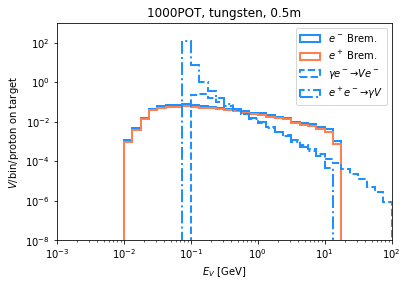

In [7]:
plt.hist(Energies['DarkBrem'][11], weights=Weights['DarkBrem'][11], bins=np.logspace(-3, 2, 41), histtype='step', lw=2, color='dodgerblue', label=r"$e^-\ \mathrm{Brem.}$")
plt.hist(Energies['DarkBrem'][-11], weights=Weights['DarkBrem'][-11], bins=np.logspace(-3, 2, 41), histtype='step', lw=2, color='coral', label=r"$e^+\ \mathrm{Brem.}$")
plt.hist(Energies['DarkComp'][22], weights=Weights['DarkComp'][22], bins=np.logspace(-3, 2, 41), histtype='step', lw=2, ls='--', color='dodgerblue', label=r"$\gamma e^- \to V e^-$")
plt.hist(Energies['DarkAnn'][-11], weights=Weights['DarkAnn'][-11], bins=np.logspace(-3, 2, 41), histtype='step', lw=2, ls='-.', color='dodgerblue', label=r"$e^+ e^- \to \gamma V$")
plt.legend(loc='best')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.gca().set_xlabel(r"$E_V\ [\mathrm{GeV}]$")
plt.gca().set_ylabel(r"$V/\mathrm{bin}/\mathrm{proton\ on\ target}$")
plt.gca().set_title(r"1000POT, tungsten, 0.5m")
plt.gca().axis([1e-3, 1e2, 1e-8, 1e3])

Text(0.5, 1.0, 'SHiP HS Detector cut, 0.5m tungsten target, 1000POT')

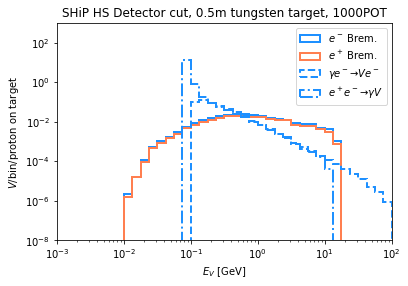

In [10]:
detector_distance = 119.5 # meters
detector_radius = 4 # meters

cut_particles_DarkBrem_electrons = detector_cut(particles['DarkBrem'][11], [detector_distance], detector_radius, method="Sample", energy_cut=None)[0]
energies = np.array([p.get_p0()[0] for p in cut_particles_DarkBrem_electrons])
weights = np.array([p.get_ids()["weight"] for p in cut_particles_DarkBrem_electrons])
plt.hist(energies, weights=weights, bins=np.logspace(-3, 2, 41), histtype='step', lw=2, color='dodgerblue', label=r"$e^-\ \mathrm{Brem.}$")

cut_particles_DarkBrem_positrons = detector_cut(particles['DarkBrem'][-11], [detector_distance], detector_radius, method="Sample", energy_cut=None)[0]
energies = np.array([p.get_p0()[0] for p in cut_particles_DarkBrem_positrons])
weights = np.array([p.get_ids()["weight"] for p in cut_particles_DarkBrem_positrons])
plt.hist(energies, weights=weights, bins=np.logspace(-3, 2, 41), histtype='step', lw=2, color='coral', label=r"$e^+\ \mathrm{Brem.}$")

cut_particles_DarkComp = detector_cut(particles['DarkComp'][22], [detector_distance], detector_radius, method="Sample", energy_cut=None)[0]
energies = np.array([p.get_p0()[0] for p in cut_particles_DarkComp])
weights = np.array([p.get_ids()["weight"] for p in cut_particles_DarkComp])
plt.hist(energies, weights=weights, bins=np.logspace(-3, 2, 41), histtype='step', lw=2, ls='--', color='dodgerblue', label=r"$\gamma e^- \to V e^-$")

cut_particles_DarkAnn = detector_cut(particles['DarkAnn'][-11], [detector_distance], detector_radius, method="Sample", energy_cut=None)[0]
energies = np.array([p.get_p0()[0] for p in cut_particles_DarkAnn])
weights = np.array([p.get_ids()["weight"] for p in cut_particles_DarkAnn])
plt.hist(energies, weights=weights, bins=np.logspace(-3, 2, 41), histtype='step', lw=2, ls='-.', color='dodgerblue', label=r"$e^+ e^- \to \gamma V$")

plt.legend(loc='best')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.gca().set_xlabel(r"$E_V\ [\mathrm{GeV}]$")
plt.gca().set_ylabel(r"$V/\mathrm{bin}/\mathrm{proton\ on\ target}$")
plt.gca().axis([1e-3, 1e2, 1e-8, 1e3])
plt.title("SHiP HS Detector cut, 0.5m tungsten target, 1000POT")